### Setup Python Path (Consistent with other notebooks)

In [1]:
import sys
import os

# Temporary add to import config
project_root_guess = os.path.abspath(os.path.join(os.getcwd(), '..'))
temp_src_path = os.path.join(project_root_guess, 'src')
if temp_src_path not in sys.path:
    sys.path.append(temp_src_path)

# Import PROJECT_ROOT and config values
from config import PROJECT_ROOT, CREDITCARD_FULL_PATH

# Remove temp and add correct path
if temp_src_path in sys.path:
    sys.path.remove(temp_src_path)

correct_src_path = os.path.join(PROJECT_ROOT, 'src')
if correct_src_path not in sys.path:
    sys.path.append(correct_src_path)

print(f"EDA Notebook Ready for Credit Card Data")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Loading from: {CREDITCARD_FULL_PATH}")

Config loaded: Project root = C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection
Raw data path = C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection\data\raw
EDA Notebook Ready for Credit Card Data
Project Root: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection
Loading from: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection\data\raw\creditcard.csv


###  Imports and Visualization Setup

In [2]:
# Imports and Visualization Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 6)

print("EDA Notebook: Credit Card Fraud Data (creditcard.csv)")

EDA Notebook: Credit Card Fraud Data (creditcard.csv)


### Load Dataset

In [3]:
# Load Dataset
print("Loading creditcard.csv...\n")

credit_df = pd.read_csv(CREDITCARD_FULL_PATH)

print(f"Dataset loaded: {credit_df.shape[0]:,} rows × {credit_df.shape[1]} columns")
print(f"Features: Time, V1–V28 (PCA-transformed), Amount, Class")

credit_df.head()

Loading creditcard.csv...

Dataset loaded: 284,807 rows × 31 columns
Features: Time, V1–V28 (PCA-transformed), Amount, Class


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Basic Data Properties

In [4]:
# Basic Data Properties
from IPython.display import display, Markdown

print("1. Dataset Overview ===\n")
display(Markdown(f"**Shape**: {credit_df.shape[0]:,} rows × {credit_df.shape[1]} columns"))
display(Markdown(f"**Columns**: {', '.join(credit_df.columns)}"))

print("2. Data Types & Info ===\n")
credit_df.info()

print("3. Missing Values ===\n")
missing = credit_df.isnull().sum()
if missing.sum() == 0:
    display(Markdown("**No missing values found!** ✅"))
else:
    display(missing[missing > 0])

print("4. Duplicate Rows ===\n")
duplicates = credit_df.duplicated().sum()
display(Markdown(f"**Duplicate transactions**: {duplicates:,} (common in real data; will be removed in preprocessing)"))

print("5. Descriptive Statistics (Numerical Features) ===\n")
display(credit_df.describe().T.round(4).style.background_gradient(cmap='Blues'))

1. Dataset Overview ===



**Shape**: 284,807 rows × 31 columns

**Columns**: Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class

2. Data Types & Info ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nul

**No missing values found!** ✅

4. Duplicate Rows ===



**Duplicate transactions**: 1,081 (common in real data; will be removed in preprocessing)

5. Descriptive Statistics (Numerical Features) ===



,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859600,47488.146000,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.000000,0.000000,1.958700,-56.407500,-0.920400,0.018100,1.315600,2.454900
V2,284807.000000,0.000000,1.651300,-72.715700,-0.598500,0.065500,0.803700,22.057700
V3,284807.000000,-0.000000,1.516300,-48.325600,-0.890400,0.179800,1.027200,9.382600
V4,284807.000000,0.000000,1.415900,-5.683200,-0.848600,-0.019800,0.743300,16.875300
V5,284807.000000,0.000000,1.380200,-113.743300,-0.691600,-0.054300,0.611900,34.801700
V6,284807.000000,0.000000,1.332300,-26.160500,-0.768300,-0.274200,0.398600,73.301600
V7,284807.000000,-0.000000,1.237100,-43.557200,-0.554100,0.040100,0.570400,120.589500
V8,284807.000000,0.000000,1.194400,-73.216700,-0.208600,0.022400,0.327300,20.007200
V9,284807.000000,-0.000000,1.098600,-13.434100,-0.643100,-0.051400,0.597100,15.595000


### Target Variable - Extreme Class Imbalance

=== Class Distribution (Target: 'Class') ===



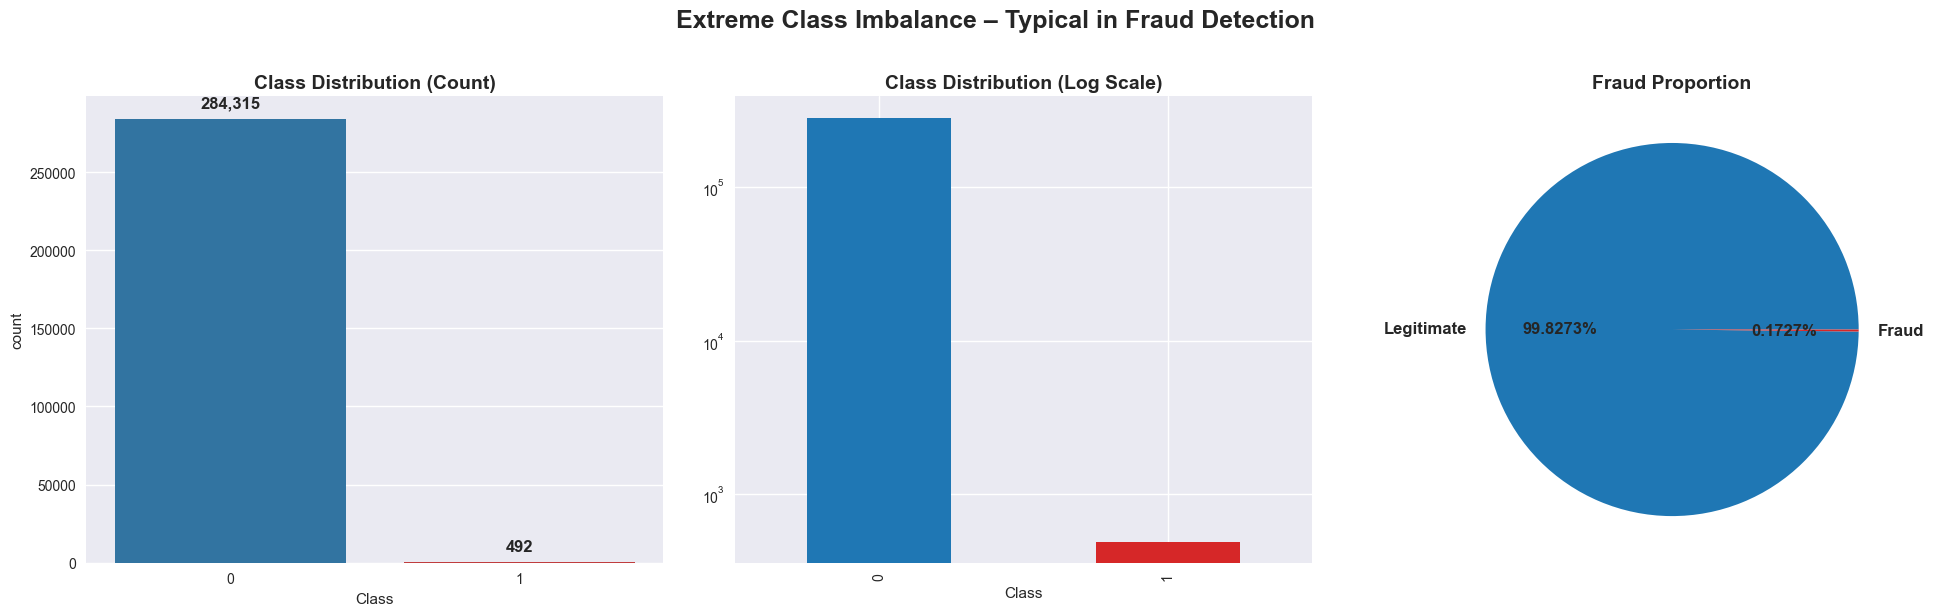

Total transactions: 284,807
Fraudulent: 492 (0.1727%)
Legitimate: 284,315 (99.8273%)
Challenge: Highly imbalanced → need PR-AUC, F1, or oversampling/undersampling


In [5]:
# Target Variable - Extreme Class Imbalance
print("=== Class Distribution (Target: 'Class') ===\n")

class_counts = credit_df['Class'].value_counts()
class_pct = credit_df['Class'].value_counts(normalize=True) * 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Count plot
sns.countplot(data=credit_df, x='Class', ax=ax1, palette=['#1f77b4', '#d62728'])
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{int(height):,}', (p.get_x() + p.get_width()/2., height + 5000),
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Log scale count (to see fraud)
credit_df['Class'].value_counts().plot(kind='bar', logy=True, ax=ax2, color=['#1f77b4', '#d62728'])
ax2.set_title('Class Distribution (Log Scale)', fontsize=14, fontweight='bold')

# Pie chart
ax3.pie(class_counts, labels=['Legitimate', 'Fraud'], autopct='%1.4f%%',
        colors=['#1f77b4', '#d62728'], textprops={'fontsize': 12, 'fontweight': 'bold'})
ax3.set_title('Fraud Proportion', fontsize=14, fontweight='bold')

plt.suptitle('Extreme Class Imbalance – Typical in Fraud Detection', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Total transactions: {len(credit_df):,}")
print(f"Fraudulent: {class_counts[1]:,} ({class_pct[1]:.4f}%)")
print(f"Legitimate: {class_counts[0]:,} ({class_pct[0]:.4f}%)")
print("Challenge: Highly imbalanced → need PR-AUC, F1, or oversampling/undersampling")

### Transaction Time and Amount Analysis

Time and Amount Features 



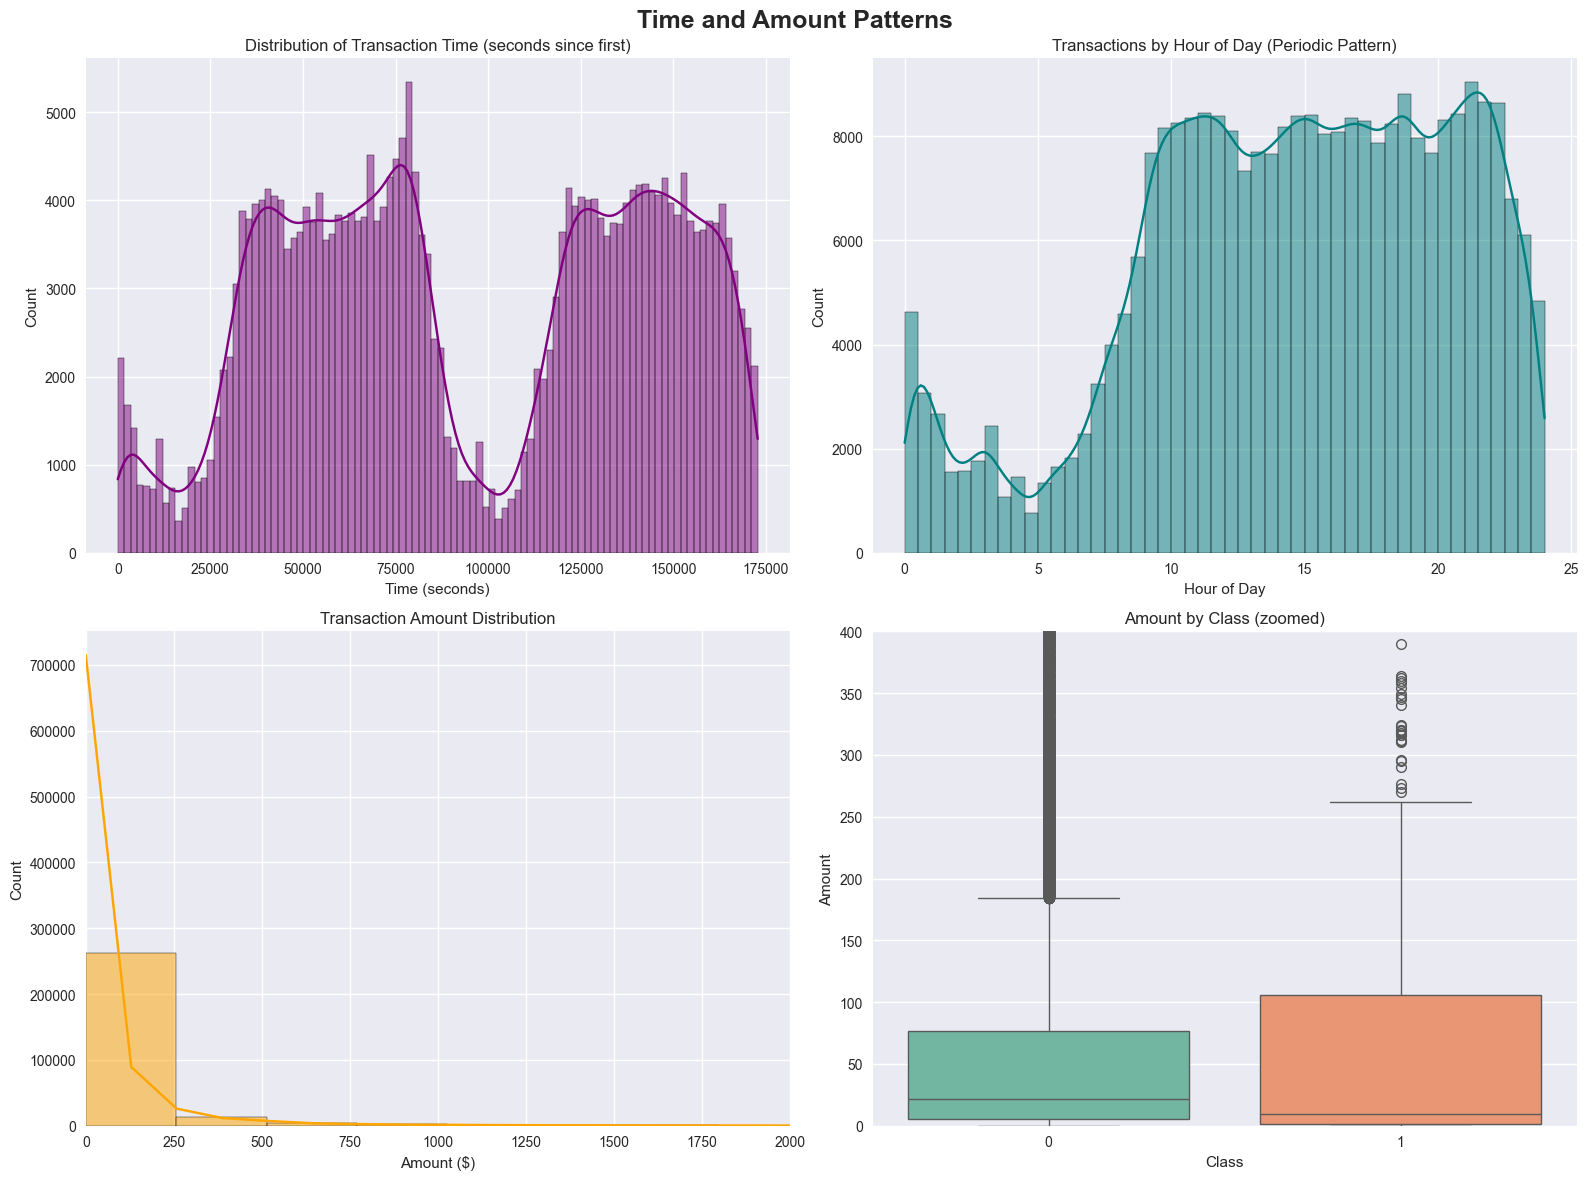

Insight: Fraudulent transactions tend to have smaller amounts and occur at different times.


In [6]:
# Transaction Time and Amount Analysis
print("Time and Amount Features \n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time distribution (seconds from first transaction)
sns.histplot(credit_df['Time'], bins=100, kde=True, ax=axes[0,0], color='purple')
axes[0,0].set_title('Distribution of Transaction Time (seconds since first)')
axes[0,0].set_xlabel('Time (seconds)')

# Convert Time to hours for periodicity
credit_df['Time_hours'] = credit_df['Time'] / 3600
sns.histplot(credit_df['Time_hours'] % 24, bins=48, kde=True, ax=axes[0,1], color='teal')
axes[0,1].set_title('Transactions by Hour of Day (Periodic Pattern)')
axes[0,1].set_xlabel('Hour of Day')

# Amount distribution
sns.histplot(credit_df['Amount'], bins=100, kde=True, ax=axes[1,0], color='orange')
axes[1,0].set_title('Transaction Amount Distribution')
axes[1,0].set_xlim(0, 2000)  # Focus on majority
axes[1,0].set_xlabel('Amount ($)')

# Amount by Class (zoomed)
sns.boxplot(data=credit_df, x='Class', y='Amount', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Amount by Class (zoomed)')
axes[1,1].set_ylim(0, 400)

plt.suptitle('Time and Amount Patterns', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("Insight: Fraudulent transactions tend to have smaller amounts and occur at different times.")

### PCA Features (V1–V28) Analysis 

=== Anonymized PCA Features (V1–V28) ===



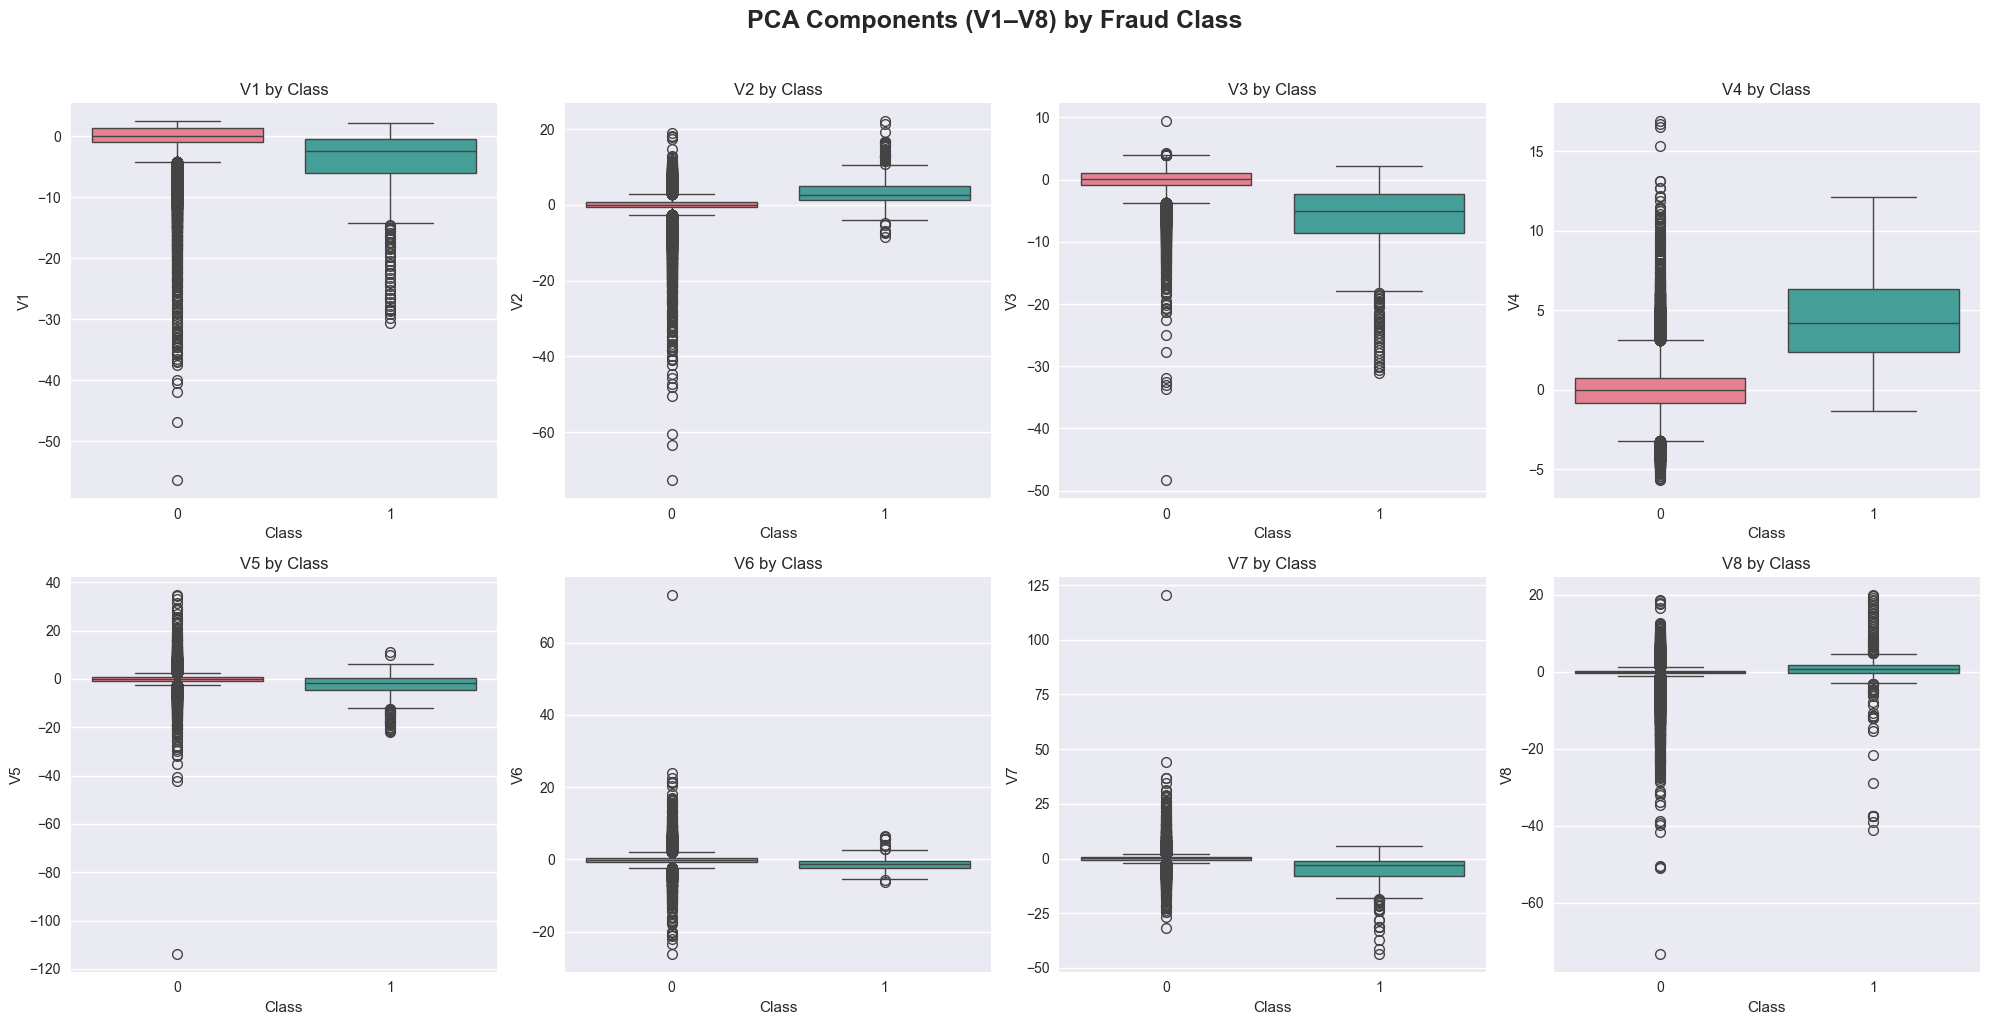

Insight: Several V features show clear separation between fraud and legitimate — PCA preserved discriminative power.


In [7]:
# PCA Features (V1–V28) Analysis 
print("=== Anonymized PCA Features (V1–V28) ===\n")

# Select a sample of 8 V features for visualization
v_features = [f'V{i}' for i in range(1, 29)]
sample_v = v_features[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(sample_v):
    sns.boxplot(data=credit_df, x='Class', y=col, ax=axes[i], palette='husl')
    axes[i].set_title(f'{col} by Class')

plt.suptitle('PCA Components (V1–V8) by Fraud Class', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Insight: Several V features show clear separation between fraud and legitimate — PCA preserved discriminative power.")

### Correlation with Target (Top Features)

=== Feature Importance Hint: Correlation with Class ===



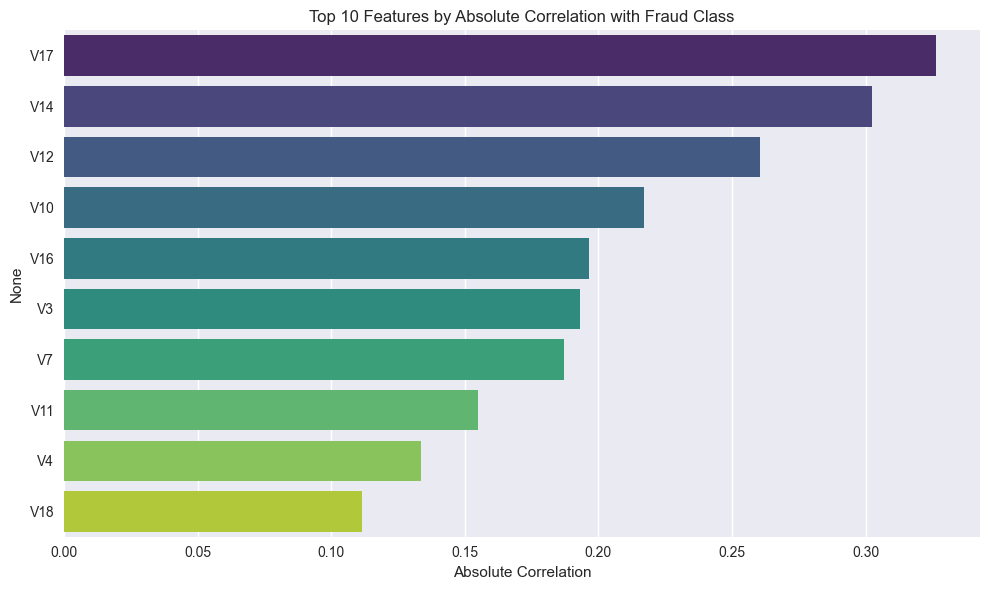

,Abs Correlation
V17,0.3265
V14,0.3025
V12,0.2606
V10,0.2169
V16,0.1965
V3,0.1930
V7,0.1873
V11,0.1549
V4,0.1334
V18,0.1115


In [8]:
# Correlation with Target (Top Features)
print("=== Feature Importance Hint: Correlation with Class ===\n")

correlations = credit_df.corr()['Class'].drop('Class').abs().sort_values(ascending=False)
top_corr = correlations.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 10 Features by Absolute Correlation with Fraud Class')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

display(top_corr.round(4).to_frame('Abs Correlation'))

In [9]:
# Summary of Key Insights
print("CREDIT CARD DATA EDA SUMMARY\n")
print("• Extremely imbalanced: Only ~0.17% fraudulent transactions")
print("• Features V1–V28 are PCA-transformed and already scaled (privacy-protected)")
print("• Amount: Fraud cases typically involve lower amounts")
print("• Time: Shows daily periodicity; fraud timing differs slightly")
print("• Several V components (e.g., V11, V4, V14, V17) strongly correlate with fraud")
print("• No missing values; duplicates present (will be removed in preprocessing)")
print("\n Dataset ready for modeling — recommend:")
print("   - Use PR-AUC as primary metric")
print("   - Apply SMOTE or class weighting")
print("   - Tree-based models (XGBoost, LightGBM) likely to perform well on PCA features")

CREDIT CARD DATA EDA SUMMARY

• Extremely imbalanced: Only ~0.17% fraudulent transactions
• Features V1–V28 are PCA-transformed and already scaled (privacy-protected)
• Amount: Fraud cases typically involve lower amounts
• Time: Shows daily periodicity; fraud timing differs slightly
• Several V components (e.g., V11, V4, V14, V17) strongly correlate with fraud
• No missing values; duplicates present (will be removed in preprocessing)

 Dataset ready for modeling — recommend:
   - Use PR-AUC as primary metric
   - Apply SMOTE or class weighting
   - Tree-based models (XGBoost, LightGBM) likely to perform well on PCA features
